# Import Liberaries 

In [106]:
import numpy as np
import cv2
from scipy.ndimage import interpolation as inter
from PIL import Image as im
from tensorflow.keras.models import load_model 

TestImage

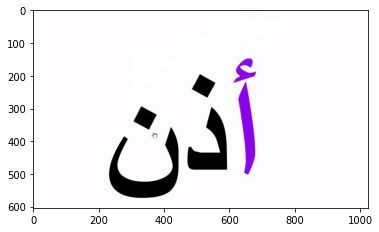

In [107]:
img = cv2.imread('ex2.jpeg')
plt.imshow(img)

# Preprocessing 


### Compute the horizontal or the vertical projection of a gray image

image project is an "histogram over horizontal or vertical way of grayscale level".

In [108]:
def projection(gray_img, axis:str='horizontal'):
    if axis == 'horizontal':
        projection_bins = np.sum(gray_img, 1).astype('int32')
    elif axis == 'vertical':
        projection_bins = np.sum(gray_img, 0).astype('int32')

    return projection_bins

test projection 

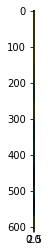

In [109]:
plt.imshow(projection(img,'horizontal'))

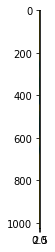

In [110]:
plt.imshow(projection(img,'vertical'))

In [111]:
# ethod to save charcaters after extrat it;
def save_image(img, folder, title):
    cv2.imwrite(f'./{folder}/{title}.png', img)


### Binarize an image


Image binarization is the process of taking a grayscale image and converting it to black-and-white, essentially reducing the information contained within the image from 256 shades of gray to 2: black and white, a binary image. 


In [112]:
def converet_to_binary(image, filter:int=1):
    if len(image.shape) == 3:
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = image

    if filter != 0:
        blur = cv2.GaussianBlur(gray_img, (3,3), 0)
        binary_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    else:
        binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    return binary_img

test binaization 

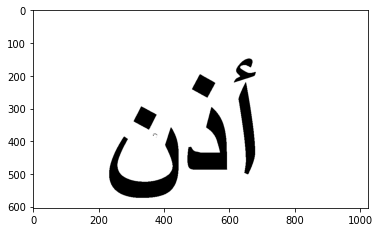

In [113]:
plt.imshow(converet_to_binary(img),cmap='gray')

In [115]:
def find_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    hist = np.sum(data, axis=1)
    score = np.sum((hist[1:] - hist[:-1]) ** 2)
    return hist, score

### Deskwe image 

 deskewing is the process of straightening an image that has been  written crookedly — that is an image that is slanting too far in one direction, or one that is misaligned.

In [116]:
def deskew(binary_img):

    
    ht, wd = binary_img.shape
    bin_img = (binary_img // 255.0)

    delta = 0.1
    limit = 3
    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    for angle in angles:
        hist, score = find_score(bin_img, angle)
        scores.append(score)

    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]

    # correct skew
    data = inter.rotate(bin_img, best_angle, reshape=False, order=0)
    img = im.fromarray((255 * data).astype("uint8"))

    # img.save('skew_corrected.png')
    pix = np.array(img)
    return pix

test

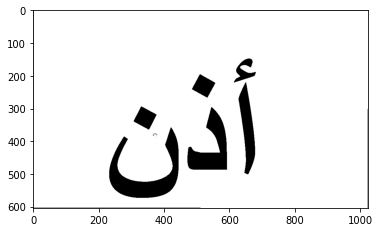

In [117]:
plt.imshow(deskew(converet_to_binary(img)),cmap='gray')

# Segmentation 

In [118]:
def preprocess(image):
    # Maybe we end up using only gray level image.
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.bitwise_not(gray_img)

    binary_img = converet_to_binary(gray_img, 0)

    deskewed_img = deskew(binary_img)
    return deskewed_img

In [119]:
def projection_segmentation(clean_img, axis, cut=3):
    
    segments = []
    start = -1
    cnt = 0

    projection_bins = projection(clean_img, axis)
    for idx, projection_bin in enumerate(projection_bins):

        if projection_bin != 0:
            cnt = 0
        if projection_bin != 0 and start == -1:
            start = idx
        if projection_bin == 0 and start != -1:
            cnt += 1
            if cnt >= cut:
                if axis == 'horizontal':
                    segments.append(clean_img[max(start-1, 0):idx, :])
                elif axis == 'vertical':
                    segments.append(clean_img[:, max(start-1, 0):idx])
                cnt = 0
                start = -1
    
    return segments

# Line Segmentation


In [120]:
def line_horizontal_projection(image, cut=3):
    # Preprocess input image
    clean_img = preprocess(image)

    # Segmentation    
    lines = projection_segmentation(clean_img, axis='horizontal', cut=cut)

    return lines


In [121]:
# Charcter Segmentation
def char_vertical_projection(line_image, cut=3):
    
    line_words = projection_segmentation(line_image, axis='vertical', cut=cut)
    line_words.reverse()
    
    return line_words

In [122]:
def extract_charcters(img, visual=0):

    lines = line_horizontal_projection(img)
    words = []
    
    for idx, line in enumerate(lines):
        
        if visual:
            save_image(line, 'lines', f'line{idx}')

        line_words = char_vertical_projection(line)
        for w in line_words:
            words.append((w, line))
    
    if visual:
        for idx, word in enumerate(words):
            save_image(word[0], 'words', f'word{idx}')

    return words

#Test

In [123]:
img = cv2.imread('ex2.jpeg')
words=extract_charcters(img, 1)

## Test Image

## Visualize Result

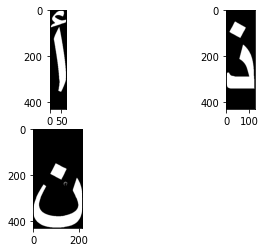

In [125]:
import matplotlib.pyplot as plt
for i in range(len(words)):
    plt.subplot(2,2,i+1)
    plt.imshow(words[i][0],cmap='gray')
plt.show()

### Sentance Recognition 

In [126]:
labels=[u'أ',u'ب',u'ت',u'ث',u'ج',u'ح',u'خ',u'د',u'ذ',u'ر',u'ز',u'س',u'ش',u'ص',u'ض',u'ط',u'ظ',u'ع',u'غ',u'ف',u'ق',u'ك',u'ل',u'لا',u'م',u'ن',u'ه',u'و',u'ي']


In [128]:
from scipy.ndimage import center_of_mass
def center(image):
    cy, cx = center_of_mass(image)

    rows, cols = image.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    M = np.float32([[1, 0, shiftx], [0, 1, shifty]])
    image = cv2.warpAffine(image, M, (cols, rows))

    return image

### Load Model 

In [131]:
model =load_model('Ar_ch_model.h5')
result=""
for i in range(len(words)-1,-1,-1):
    image=cv2.resize(center(words[i][0]),(32,32))
    result+=(labels[model.predict((image).reshape(-1,32,32,1)).argmax(axis=1)[0]])

## Result

In [132]:
print(result)

أذن


# Refernces

Arabic Character Segmentation Using Projection Based Approach with Profile's Amplitude Filter .

https://github.com/HusseinYoussef/Arabic-OCR